In [134]:
import utils.gn as gn 
import utils.generator as gen
import utils.visualization as viz

import torch_geometric
from torch_geometric.data import Data
import torch

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from tqdm import tqdm

from plot2vid import PlotRecorder


In [135]:
path = 'datasets/fluids'

water_particles, water_frames = [], []
elastic_particles, elastic_frames = [], []
snow_particles, snow_frames = [], []
sand_particles, sand_frames = [], []

for sample in tqdm(range(30)):
    water_particles.append(torch.load(f'{path}/particles/water_test_{sample}'))
    elastic_particles.append(torch.load(f'{path}/particles/elastic_test_{sample}'))
    snow_particles.append(torch.load(f'{path}/particles/snow_test_{sample}'))
    sand_particles.append(torch.load(f'{path}/particles/sand_test_{sample}'))

    water_frames.append(torch.load(f'{path}/frames/water_test_{sample}'))
    elastic_frames.append(torch.load(f'{path}/frames/elastic_test_{sample}'))
    snow_frames.append(torch.load(f'{path}/frames/snow_test_{sample}'))
    sand_frames.append(torch.load(f'{path}/frames/sand_test_{sample}'))

all_particles = [*water_particles, *elastic_particles, *snow_particles, *sand_particles]
all_frames = [*water_frames, *elastic_frames, *snow_frames, *sand_frames]

100%|██████████| 30/30 [00:01<00:00, 26.17it/s]


In [136]:
n_trajectories = len(all_particles)
trajectory_length = water_particles[0].shape[0]
video_shape = all_frames[0].shape

In [137]:
all_particles[0].shape

(400, 92, 2)

In [138]:
particle_trajectories = all_particles
raw_videos = torch.zeros((len(all_frames), *video_shape), dtype=torch.float32)

In [139]:
for i, frame in enumerate(all_frames):
    raw_videos[i] = torch.tensor(frame, dtype=torch.float32) / 255

In [140]:
for i, particles in enumerate(all_particles):
    particle_trajectories[i] = torch.tensor(particles, dtype=torch.float32)

In [141]:
STEP = 0.01
MAX_FPS = 100
RESOLUTION = 64

PHYSICAL_HIDDEN_ENCODING_SIZE = 32
PHYSICAL_ENCODING_SIZE = 4

EDGE_EMBEDDING_SIZE = 48
NODE_EMBEDDING_SIZE = 48
NUM_GN_LAYERS = 3
GN_PROCESSOR_DEPTH = 1
PAST_VELOCITIES = 3
GRAPH_NETWORK_EPOCHS = 2
CONNECTIVITY_RADIUS=0.12
EDGE_NOISE_STD = 0.0
PARTICLE_NOISE_STD = 0.0
MIN_STEP = 100
LIMIT_EDGES_PER_PARTICLE = 100000

In [142]:
videos = raw_videos[:,::(MAX_FPS // 20)]

In [143]:
videos.shape

torch.Size([120, 80, 64, 64, 3])

In [144]:
from utils.video import ConvVideoEncoder
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
import torch.nn as nn
from utils.builder import build_mlp

class VideoEncoder(nn.Module):
    def __init__(self, 
                 frame_encoder: nn.Module,
                 latent_frame_size: int,
                 encoding_size: int,
                 hidden_state_size=32,
                 num_lstm_layers=1):
        super(VideoEncoder, self).__init__()

        self.hidden_state_size = hidden_state_size

        self.frame_encoder = frame_encoder

        self.linear_in = nn.Linear(latent_frame_size, hidden_state_size)
        self.lstm = nn.LSTM(hidden_state_size, hidden_state_size, num_layers=num_lstm_layers, batch_first=True)
        self.linear_out = nn.Linear(hidden_state_size, encoding_size)
        self.activation = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, seq_length, height, width, channels = x.shape

        x = self.frame_encoder(x.view(batch_size * seq_length, height, width, channels)).view(batch_size, seq_length, -1)

        x = self.linear_in(x)
        x = self.activation(x)

        x, _ = self.lstm(x)

        x = self.activation(x)
        x = self.linear_out(x)
        x = self.activation(x)

        return x

video_encoder = torch.load('models/fluids/experiments/additional_0_fps=20_classes=4_epoch=50.torch')

In [145]:
video_encoder

VideoEncoder(
  (frame_encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Sequential(
      (0): Linear(in_features=12288, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=192, bias=True)
      (3): ReLU()
      (4): Linear(in_features=192, out_features=192, bias=True)
      (5): ReLU()
    )
  )
  (linear_in): Linear(in_features=192, out_features=32, bias=True)
  (lstm): LSTM(32, 32, batch_first=True)
  (linear_out): Linear(in_features=32, out_features=4, bias=True)
  (activation): Tanh()
  (sigmoid): Sigmoid()
)

In [146]:
res = video_encoder(videos)[:,-1]

In [154]:
graph_dataset = torch.load('datasets/fluids/evaluation_classes=4_samples=30.torch')

In [155]:
graph_dataset.edge_noise_std = 0
graph_dataset.particle_noise_std = 0
graph_dataset.video_encoder = video_encoder


In [156]:
graph_dataset_loader = DataLoader(graph_dataset, batch_size=8, shuffle=True)
validation_graph_dataset_loader = DataLoader(graph_dataset, batch_size=8, shuffle=True)

In [157]:
eval_dataset_size = len(graph_dataset)

In [158]:
dataset_size_per_class = eval_dataset_size // 4

In [159]:
graph_network = torch.load('models/fluids/experiments/model_fps=20_classes=4_epoch=50.torch')
base_graph_network = torch.load('models/fluids/experiments/model_baseline_fps=20_classes=4_epoch=50.torch')


In [160]:
# Order: water, elastic, snow, sand

errors = torch.zeros((4, eval_dataset_size), dtype=torch.float32)
graph_dataset.one_hot_encode_class = False
for c in range(4):
    for sample in range(dataset_size_per_class):
        graph = graph_dataset[c * dataset_size_per_class + sample].clone()
        predicted_graph = graph_network(graph).detach()

        errors[c][sample] = torch.sqrt(torch.sum(torch.square(graph.y - predicted_graph.x)).detach()).detach()

In [161]:
# Order: water, elastic, snow, sand

base_errors = torch.zeros((4, eval_dataset_size), dtype=torch.float32)
graph_dataset.one_hot_encode_class = True

for c in range(4):
    for sample in range(dataset_size_per_class):
        graph = graph_dataset[c * dataset_size_per_class + sample].clone()
        predicted_graph = base_graph_network(graph).detach()

        base_errors[c][sample] = torch.sqrt(torch.sum(torch.square(graph.y - predicted_graph.x)).detach()).detach()

In [162]:
print('One-Step MED:\tVEGN\t\tBaseline')
print(f'\tWater: \t{(1e4 * torch.mean(errors[0])):.2f}+-{1e4 * torch.var(errors[0]):.5f} \t{(1e4 * torch.mean(base_errors[0])):.2f}+-{1e4 * torch.var(base_errors[0]):.5f}')
print(f'\tSnow: \t{(1e4 * torch.mean(errors[2])):.2f}+-{1e4 * torch.var(errors[2]):.5f} \t{(1e4 * torch.mean(base_errors[2])):.2f}+-{1e4 * torch.var(base_errors[2]):.5f}')
print(f'\tSand: \t{(1e4 * torch.mean(errors[3])):.2f}+-{1e4 * torch.var(errors[3]):.5f} \t{(1e4 * torch.mean(base_errors[3])):.2f}+-{1e4 * torch.var(base_errors[3]):.5f}')
print(f'\tElas: \t{(1e4 * torch.mean(errors[1])):.2f}+-{1e4 * torch.var(errors[1]):.5f} \t{(1e4 * torch.mean(base_errors[1])):.2f}+-{1e4 * torch.var(base_errors[1]):.5f}')

One-Step MED:	VEGN		Baseline
	Water: 	2.87+-0.00820 	2.76+-0.00747
	Snow: 	1.07+-0.00301 	1.01+-0.00327
	Sand: 	0.78+-0.00266 	0.62+-0.00241
	Elas: 	4.24+-0.02445 	4.15+-0.02461


In [163]:
print('Encoding variance')
print(f'\tWater: {torch.var(water_encodings)}')
print(f'\tSnow: {torch.var(snow_encodings)}')
print(f'\tSand: {torch.var(sand_encodings)}')
print(f'\tElastic: {torch.var(elastic_encodings)}')

Encoding variance
	Water: 0.18285655975341797
	Snow: 0.15164688229560852
	Sand: 0.19105164706707
	Elastic: 0.06584959477186203


In [164]:
torch.set_printoptions(sci_mode=False)

In [165]:
graph_dataset.edge_noise_std = 0
graph_dataset.particle_noise_std = 0
graph_dataset.video_encoder = video_encoder
graph_dataset.one_hot_encode_class = False

In [166]:
def infer_trajectory(model, video_encoder, videos, initial_position, initial_graph, initial_velocity, time_steps=100):
    trajectory = torch.zeros((time_steps, *initial_position.shape), dtype=torch.float32)
    trajectory[0] = initial_position

    velocity = initial_velocity
    graph = initial_graph.clone()

    if video_encoder is not None:
        encodings = video_encoder(videos)[:,-1]
        encoding = torch.mean(encodings, dim=0)
        graph.x[:,-encoding.shape[0]:] = encoding

    for i in tqdm(range(1, time_steps)):
        accelerations = model(graph.clone())
        velocity += accelerations.x
        
        trajectory[i] = trajectory[i - 1] + velocity
        velocity = trajectory[i] - trajectory[i - 1]
        graph.x[:,2:2*PAST_VELOCITIES] = graph.x[:,:2*(PAST_VELOCITIES - 1)]
        graph.x[:,:2] = velocity
        graph.edge_index = gn.get_connectivity(particles=trajectory[i].detach(), system='fluid', radius=CONNECTIVITY_RADIUS)
        graph.edge_attr = gn.get_edge_attributes(graph.edge_index, trajectory[i])

        for k, particle in enumerate(graph.x):
            dist_to_top = min(CONNECTIVITY_RADIUS, 1 - trajectory[i][k][1])
            dist_to_left = min(CONNECTIVITY_RADIUS, trajectory[i][k][0])
            dist_to_right = min(CONNECTIVITY_RADIUS, 1 - trajectory[i][k][0])
            dist_to_bottom = min(CONNECTIVITY_RADIUS, trajectory[i][k][1])

            graph.x[k, -1 - 4] = dist_to_top
            graph.x[k, -2 - 4] = dist_to_left
            graph.x[k, -3 - 4] = dist_to_right
            graph.x[k, -4 - 4] = dist_to_bottom

    return trajectory.detach().numpy()
    

In [167]:
water_videos = videos[:30]
elastic_videos = videos[30:60]
snow_videos = videos[60:90]
sand_videos = videos[90:]

In [168]:
graph_dataset.minimum_rollout_step = 0
graph_dataset.one_hot_encode_class = False

In [169]:
TRAJ = 15
STEP = 100
water_trajectory = particle_trajectories[TRAJ][STEP:]

trajectory_length = STEP + water_trajectory.shape[0]
predicted_water_trajectory = infer_trajectory(
    model=base_graph_network,
    video_encoder=video_encoder,
    videos=water_videos,
    initial_position=water_trajectory[0],
    initial_velocity = graph_dataset[TRAJ * (trajectory_length - 2) + STEP].x[:,:2],
    initial_graph=graph_dataset[TRAJ * trajectory_length + STEP],
    time_steps=300
)

100%|██████████| 299/299 [01:01<00:00,  4.87it/s]


In [170]:
TRAJ = 54
STEP = 100
elastic_trajectory = particle_trajectories[TRAJ][STEP:]

trajectory_length = STEP + elastic_trajectory.shape[0]
predicted_elastic_trajectory = infer_trajectory(
    model=graph_network,
    video_encoder=video_encoder,
    videos=elastic_videos,
    initial_position=elastic_trajectory[0],
    initial_velocity = graph_dataset[TRAJ * (trajectory_length - 2) + STEP].x[:,:2],
    initial_graph=graph_dataset[TRAJ * trajectory_length + STEP],
    time_steps=300
)

100%|██████████| 299/299 [00:06<00:00, 47.12it/s]


In [171]:
TRAJ = 81
STEP = 100
snow_trajectory = particle_trajectories[TRAJ][STEP:]

trajectory_length = STEP + snow_trajectory.shape[0]
predicted_snow_trajectory = infer_trajectory(
    model=graph_network,
    video_encoder=video_encoder,
    videos=snow_videos,
    initial_position=snow_trajectory[0],
    initial_velocity = graph_dataset[TRAJ * (trajectory_length - 2) + STEP].x[:,:2],
    initial_graph=graph_dataset[TRAJ * trajectory_length + STEP],
    time_steps=300
)

100%|██████████| 299/299 [00:10<00:00, 27.74it/s]


In [172]:
TRAJ = 97
STEP = 100
sand_trajectory = particle_trajectories[TRAJ][STEP:]

trajectory_length = STEP + sand_trajectory.shape[0]
predicted_sand_trajectory = infer_trajectory(
    model=graph_network,
    video_encoder=video_encoder,
    videos=sand_videos,
    initial_position=sand_trajectory[0],
    initial_velocity = graph_dataset[TRAJ * (trajectory_length - 2) + STEP].x[:,:2],
    initial_graph=graph_dataset[TRAJ * trajectory_length + STEP],
    time_steps=300
)

100%|██████████| 299/299 [00:14<00:00, 21.14it/s]


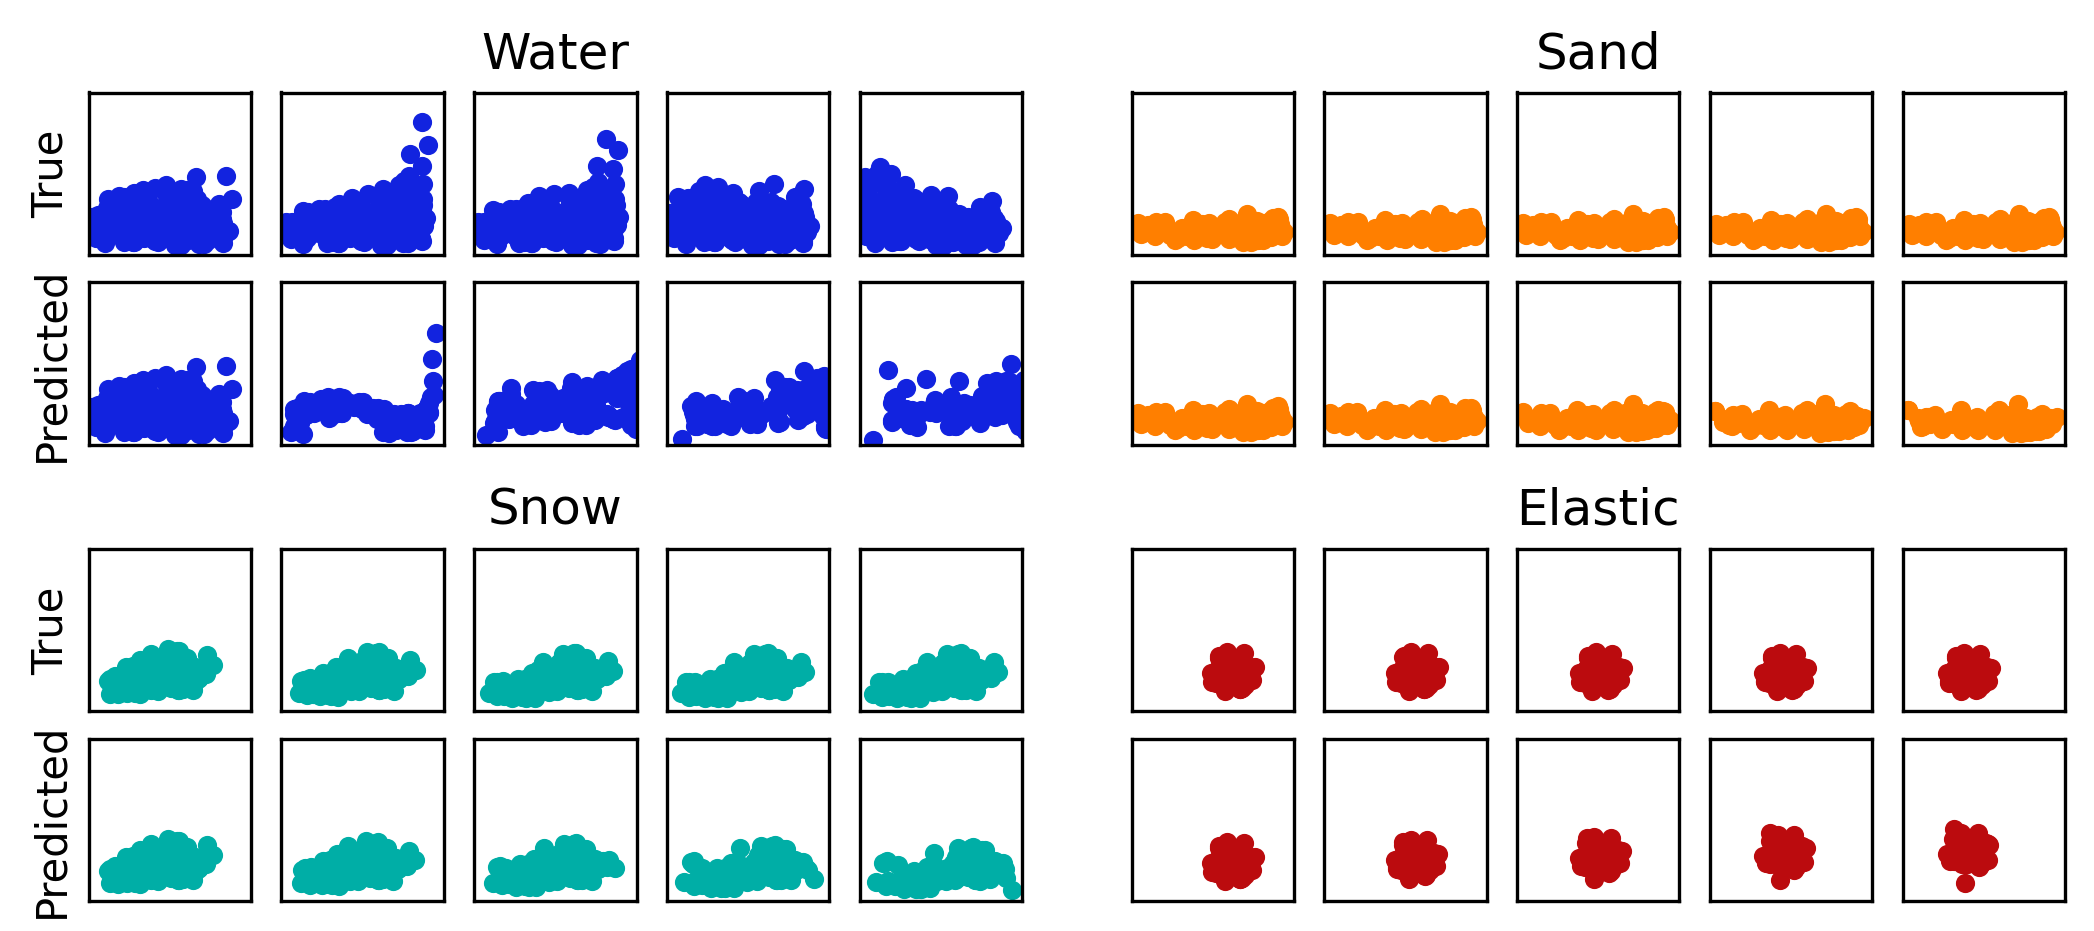

In [173]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Define a grid with 11 columns, and set the width ratios such that there is a gap between the 5th and 6th columns
fig = plt.figure(figsize=(8.5, 3.5), dpi=300)
gs = GridSpec(5, 11, width_ratios=[1, 1, 1, 1, 1, 0.3, 1, 1, 1, 1, 1], height_ratios=[1,1,0.3,1,1], hspace=0.2)

# Create subplots
axs = []
for y in range(5):
    row = []
    for x in range(11):
        ax = fig.add_subplot(gs[y, x])
        ax.set_xlim(0, 1)
        ax.set_ylim(-0.05, 1)
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_yticklabels([])
        row.append(ax)
    axs.append(row)

for x in range(11):
    axs[2][x].set_frame_on(False)
    
for y in range(5):
    axs[y][5].set_frame_on(False)  # Remove the frame around each subplot

axs[0][0].set_ylabel('True')
axs[1][0].set_ylabel('Predicted')

axs[3][0].set_ylabel('True')
axs[4][0].set_ylabel('Predicted')

PARTICLE_SIZE = 13

# Plot data
for i, timestep in enumerate(range(0, 100, 20)):
    axs[0][2].set_title('Water')
    axs[0][i].scatter(water_trajectory[timestep,:,0], water_trajectory[timestep,:,1], s=PARTICLE_SIZE, c=styles['water'])
    axs[1][i].scatter(predicted_water_trajectory[timestep,:,0], predicted_water_trajectory[timestep,:,1], s=PARTICLE_SIZE, c=styles['water'])

    axs[3][2].set_title('Snow')
    axs[3][i].scatter(snow_trajectory[timestep,:,0], snow_trajectory[timestep,:,1], s=PARTICLE_SIZE, c=styles['snow'])
    axs[4][i].scatter(predicted_snow_trajectory[timestep,:,0], predicted_snow_trajectory[timestep,:,1], s=PARTICLE_SIZE, c=styles['snow'])

    axs[0][8].set_title('Sand')
    axs[0][i + 6].scatter(sand_trajectory[timestep,:,0], sand_trajectory[timestep,:,1], s=PARTICLE_SIZE, c=styles['sand'])
    axs[1][i + 6].scatter(predicted_sand_trajectory[timestep,:,0], predicted_sand_trajectory[timestep,:,1], s=PARTICLE_SIZE, c=styles['sand'])

    axs[3][8].set_title('Elastic')
    axs[3][i + 6].scatter(elastic_trajectory[timestep,:,0], elastic_trajectory[timestep,:,1], s=PARTICLE_SIZE, c=styles['elastic'])
    axs[4][i + 6].scatter(predicted_elastic_trajectory[timestep,:,0], predicted_elastic_trajectory[timestep,:,1], s=PARTICLE_SIZE, c=styles['elastic'])

# Save figure
plt.savefig('results/fluid_trajectories.pdf', bbox_inches='tight')


In [ ]:
vegn_predicted_trajectories = []
baseline_predicted_trajectories = []
true_trajectories = []

STEP = 100

for TRAJ in range(120):
    print(TRAJ)
    trajectory = particle_trajectories[TRAJ][STEP:]
    true_trajectories.append(trajectory)
    trajectory_length = STEP + trajectory.shape[0]
    graph_network.one_hot_encode_class = False

    cur_videos = water_videos
    if TRAJ >= 30:
        cur_videos = elastic_videos
    if TRAJ >= 60:
        cur_videos = snow_videos
    if TRAJ >= 90:
        cur_videos = sand_videos

    vegn_trajectory = infer_trajectory(
        model=graph_network,
        video_encoder=video_encoder,
        videos=cur_videos,
        initial_position=trajectory[0],
        initial_velocity = graph_dataset[TRAJ * (trajectory_length - 2) + STEP].x[:,:2],
        initial_graph=graph_dataset[TRAJ * trajectory_length + STEP],
        time_steps=300
    )
    graph_dataset.one_hot_encode_class = True
    base_trajectory = infer_trajectory(
        model=base_graph_network,
        video_encoder=None,
        videos=None,
        initial_position=trajectory[0],
        initial_velocity = graph_dataset[TRAJ * (trajectory_length - 2) + STEP].x[:,:2],
        initial_graph=graph_dataset[TRAJ * trajectory_length + STEP],
        time_steps=300
    )

    vegn_predicted_trajectories.append(vegn_trajectory)
    baseline_predicted_trajectories.append(base_trajectory)

In [175]:
import ot

def sinkhorn_distance(tensor1, tensor2, reg=1e-3):
    n = tensor1.shape[0]

    t1 = tensor1.copy()
    t2 = tensor2.copy()

    t1[:,0] = np.minimum(t1[:,0], np.ones_like(t1[:,0]))
    t1[:,0] = np.maximum(t1[:,0], np.zeros_like(t1[:,0]))
    t1[:,1] = np.minimum(t1[:,1], np.ones_like(t1[:,1]))
    t1[:,1] = np.maximum(t1[:,1], np.zeros_like(t1[:,1]))

    t2[:,0] = np.minimum(t2[:,0], np.ones_like(t2[:,0]))
    t2[:,0] = np.maximum(t2[:,0], np.zeros_like(t2[:,0]))
    t2[:,1] = np.minimum(t2[:,1], np.ones_like(t2[:,1]))
    t2[:,1] = np.maximum(t2[:,1], np.zeros_like(t2[:,1]))
    
    a = np.ones(n) / n
    b = np.ones(n) / n
    
    cost_matrix = ot.dist(t1, t2, metric='euclidean')
    
    sinkhorn_dist = ot.emd2(a, b, cost_matrix)
    
    return sinkhorn_dist

In [ ]:
vegn_rollout_errors = np.zeros((120, 300))
base_rollout_errors = np.zeros((120, 300))

for i, (vt, bt, tt) in enumerate(zip(vegn_predicted_trajectories, baseline_predicted_trajectories, true_trajectories)):
    tt = tt.detach().numpy()
    for step, (svt, sbt, stt) in enumerate(zip(vt, bt, tt)):
        vErr = sinkhorn_distance(svt, stt)
        bErr = sinkhorn_distance(sbt, stt)

        vegn_rollout_errors[i,step] = vErr 
        base_rollout_errors[i,step] = bErr         

In [178]:
mean_water_encoding = torch.mean(water_encodings, dim=0)
mean_snow_encoding = torch.mean(snow_encodings, dim=0)
mean_sand_encoding = torch.mean(sand_encodings, dim=0)
mean_elastic_encoding = torch.mean(elastic_encodings, dim=0)

In [179]:
mixes = torch.zeros((4, 4, 10, 4), dtype=torch.float32)
results_r22 = torch.zeros((4, 4, len(graph_dataset) // 100)) 

In [180]:
for from_index, from_encoding in enumerate([mean_water_encoding, mean_snow_encoding, mean_sand_encoding, mean_elastic_encoding]):
    for to_index, to_encoding in enumerate([mean_water_encoding, mean_snow_encoding, mean_sand_encoding, mean_elastic_encoding]):
        mixes[from_index][to_index] = torch.tensor(np.linspace(from_encoding.detach(), to_encoding.detach(), 10))

In [181]:
# Order: water, elastic, snow, sand
from sklearn.metrics import r2_score

res_index = 0
graph_dataset.one_hot_encode_class = True

graph_dataset.one_hot_encode_class = True
for index in tqdm(range(len(graph_dataset))):
    if index % 100 != 0 or res_index >= len(graph_dataset) // 100:
        continue
    for from_index, from_encoding in enumerate([mean_water_encoding, mean_snow_encoding, mean_sand_encoding, mean_elastic_encoding]):
        for to_index, to_encoding in enumerate([mean_water_encoding, mean_snow_encoding, mean_sand_encoding, mean_elastic_encoding]):
            graph_base = graph_dataset[index].clone()
            graphs = []
            for inter in range(10):
                graph_interp = graph_base.clone()
                graph_interp.x[:,-4:] = mixes[from_index][to_index][inter]
                graphs.append(graph_network(graph_interp).x)

            first_graph = graphs[0]
            last_graph = graphs[-1]
            in_between_linear_graphs = torch.tensor(np.linspace(first_graph.detach(), last_graph.detach(), 10))
            predicted_graphs_as_tensor = torch.zeros_like(in_between_linear_graphs)

            for inter in range(10):
                predicted_graphs_as_tensor[inter] = graphs[inter]
            
            results_r22[from_index][to_index][res_index] = r2_score(in_between_linear_graphs.reshape((-1, 2)).detach(), predicted_graphs_as_tensor.reshape((-1, 2)).detach())
    res_index += 1

100%|██████████| 47760/47760 [02:22<00:00, 334.30it/s]


In [182]:
results_r2_mean = torch.mean(results_r22, dim=2)

In [ ]:
def get_sample(material, name, time_in_seconds=2, friction_angle=45):
    center = [0.1 + 0.8 * random.random(), 0.1 + 0.8 * random.random()]
    max_radius = min(center[0], center[1], 1 - center[0], 1 - center[1])
    radius = min(0.1 + 0.5 * random.random(), max_radius)

    p, v = generate_granular_trajectory(
        material, 
        time_in_seconds=time_in_seconds, 
        video_resolution=64, 
        sim_resolution=12, 
        center=center,
        radius=radius,
        friction_angle=friction_angle
    )
    vid = make_dataset_video(v, kernel=5)

    recorder = PlotRecorder(f'{name}.mp4', fps=15)
    fig, axs = plt.subplots(1, 2, figsize=(8,4), dpi=100)

    for i in tqdm(range(vid.shape[0])):
        if i % 5 == 0:
            axs[0].imshow(vid[i])
            axs[1].clear()
            axs[1].scatter(p[i,:,0], p[i,:,1])
            axs[1].axis('equal')
            axs[1].set_xlim(0,1.0)
            axs[1].set_ylim(0,1)

            recorder.add(fig)

    recorder.close()

    return p, vid

In [ ]:
videos = []
videos_flat = []
trajectories_of_parts = []

angles = np.linspace(0, 45, 15)

for angle in angles:
    torch.save(videos, f'all_videos_now_{angle}.vids')
    videos.append([])
    for sample in range(4):
        parts, frames = get_sample('SAND', f'datasets/fluids/videos/sand_friction_{angle}_{sample}', friction_angle=angle, time_in_seconds=4)
        trajectories_of_parts.append(parts)

        videos[-1].append(frames)
        videos_flat.append(frames)

videos_for_dataset = torch.zeros((60, 80, 64, 64, 3))

for i, vid in enumerate(videos_flat):
    videos_for_dataset[i] = torch.tensor(videos_flat[i][::5], dtype=torch.float32)

trajectories_for_dataset = trajectories_of_parts
for i, parts in enumerate(trajectories_of_parts):
    trajectories_for_dataset[i] = torch.tensor(parts, dtype=torch.float32)


In [ ]:
STEP = 0.01
MAX_FPS = 100
RESOLUTION = 64

PHYSICAL_HIDDEN_ENCODING_SIZE = 32
PHYSICAL_ENCODING_SIZE = 4

EDGE_EMBEDDING_SIZE = 48
NODE_EMBEDDING_SIZE = 48
NUM_GN_LAYERS = 3
GN_PROCESSOR_DEPTH = 1
PAST_VELOCITIES = 3
GRAPH_NETWORK_EPOCHS = 2
CONNECTIVITY_RADIUS=0.12
EDGE_NOISE_STD = 0.0
PARTICLE_NOISE_STD = 0.0
MIN_STEP = 50
LIMIT_EDGES_PER_PARTICLE = 100000

In [ ]:
water_to_sand_graph_dataset = gn.ParticleVideoDataset(
    number_of_classes=15,
    raw_particles=trajectories_for_dataset, 
    videos=videos_for_dataset,
    video_encoder=None,
    system='fluid',
    past_velocities=PAST_VELOCITIES,
    connectivity_radius=CONNECTIVITY_RADIUS,
    edge_noise_std=EDGE_NOISE_STD,
    particle_noise_std=PARTICLE_NOISE_STD,
    minimum_rollout_step=MIN_STEP,
    limit_edges_per_particle=LIMIT_EDGES_PER_PARTICLE
)

In [ ]:
water_to_sand_graph_dataset.video_encoder = video_encoder
water_to_sand_graph_dataset.one_hot_encode_class = False

In [ ]:
samples_per_class = len(water_to_sand_graph_dataset) // 15

In [ ]:
errors = torch.zeros((15, samples_per_class), dtype=torch.float32)

for cl in range(15):
    for sam in tqdm(range(samples_per_class)):
        index = cl * samples_per_class + sam
        inp = water_to_sand_graph_dataset[index].clone()
        pred = graph_network(inp)

        errors[cl,sam] = torch.mean(torch.square(pred.x - inp.y)).detach()

In [ ]:
errors_friction_angles = torch.mean(errors, dim=1).detach()
friction_angles = np.linspace(0, 45, 15)

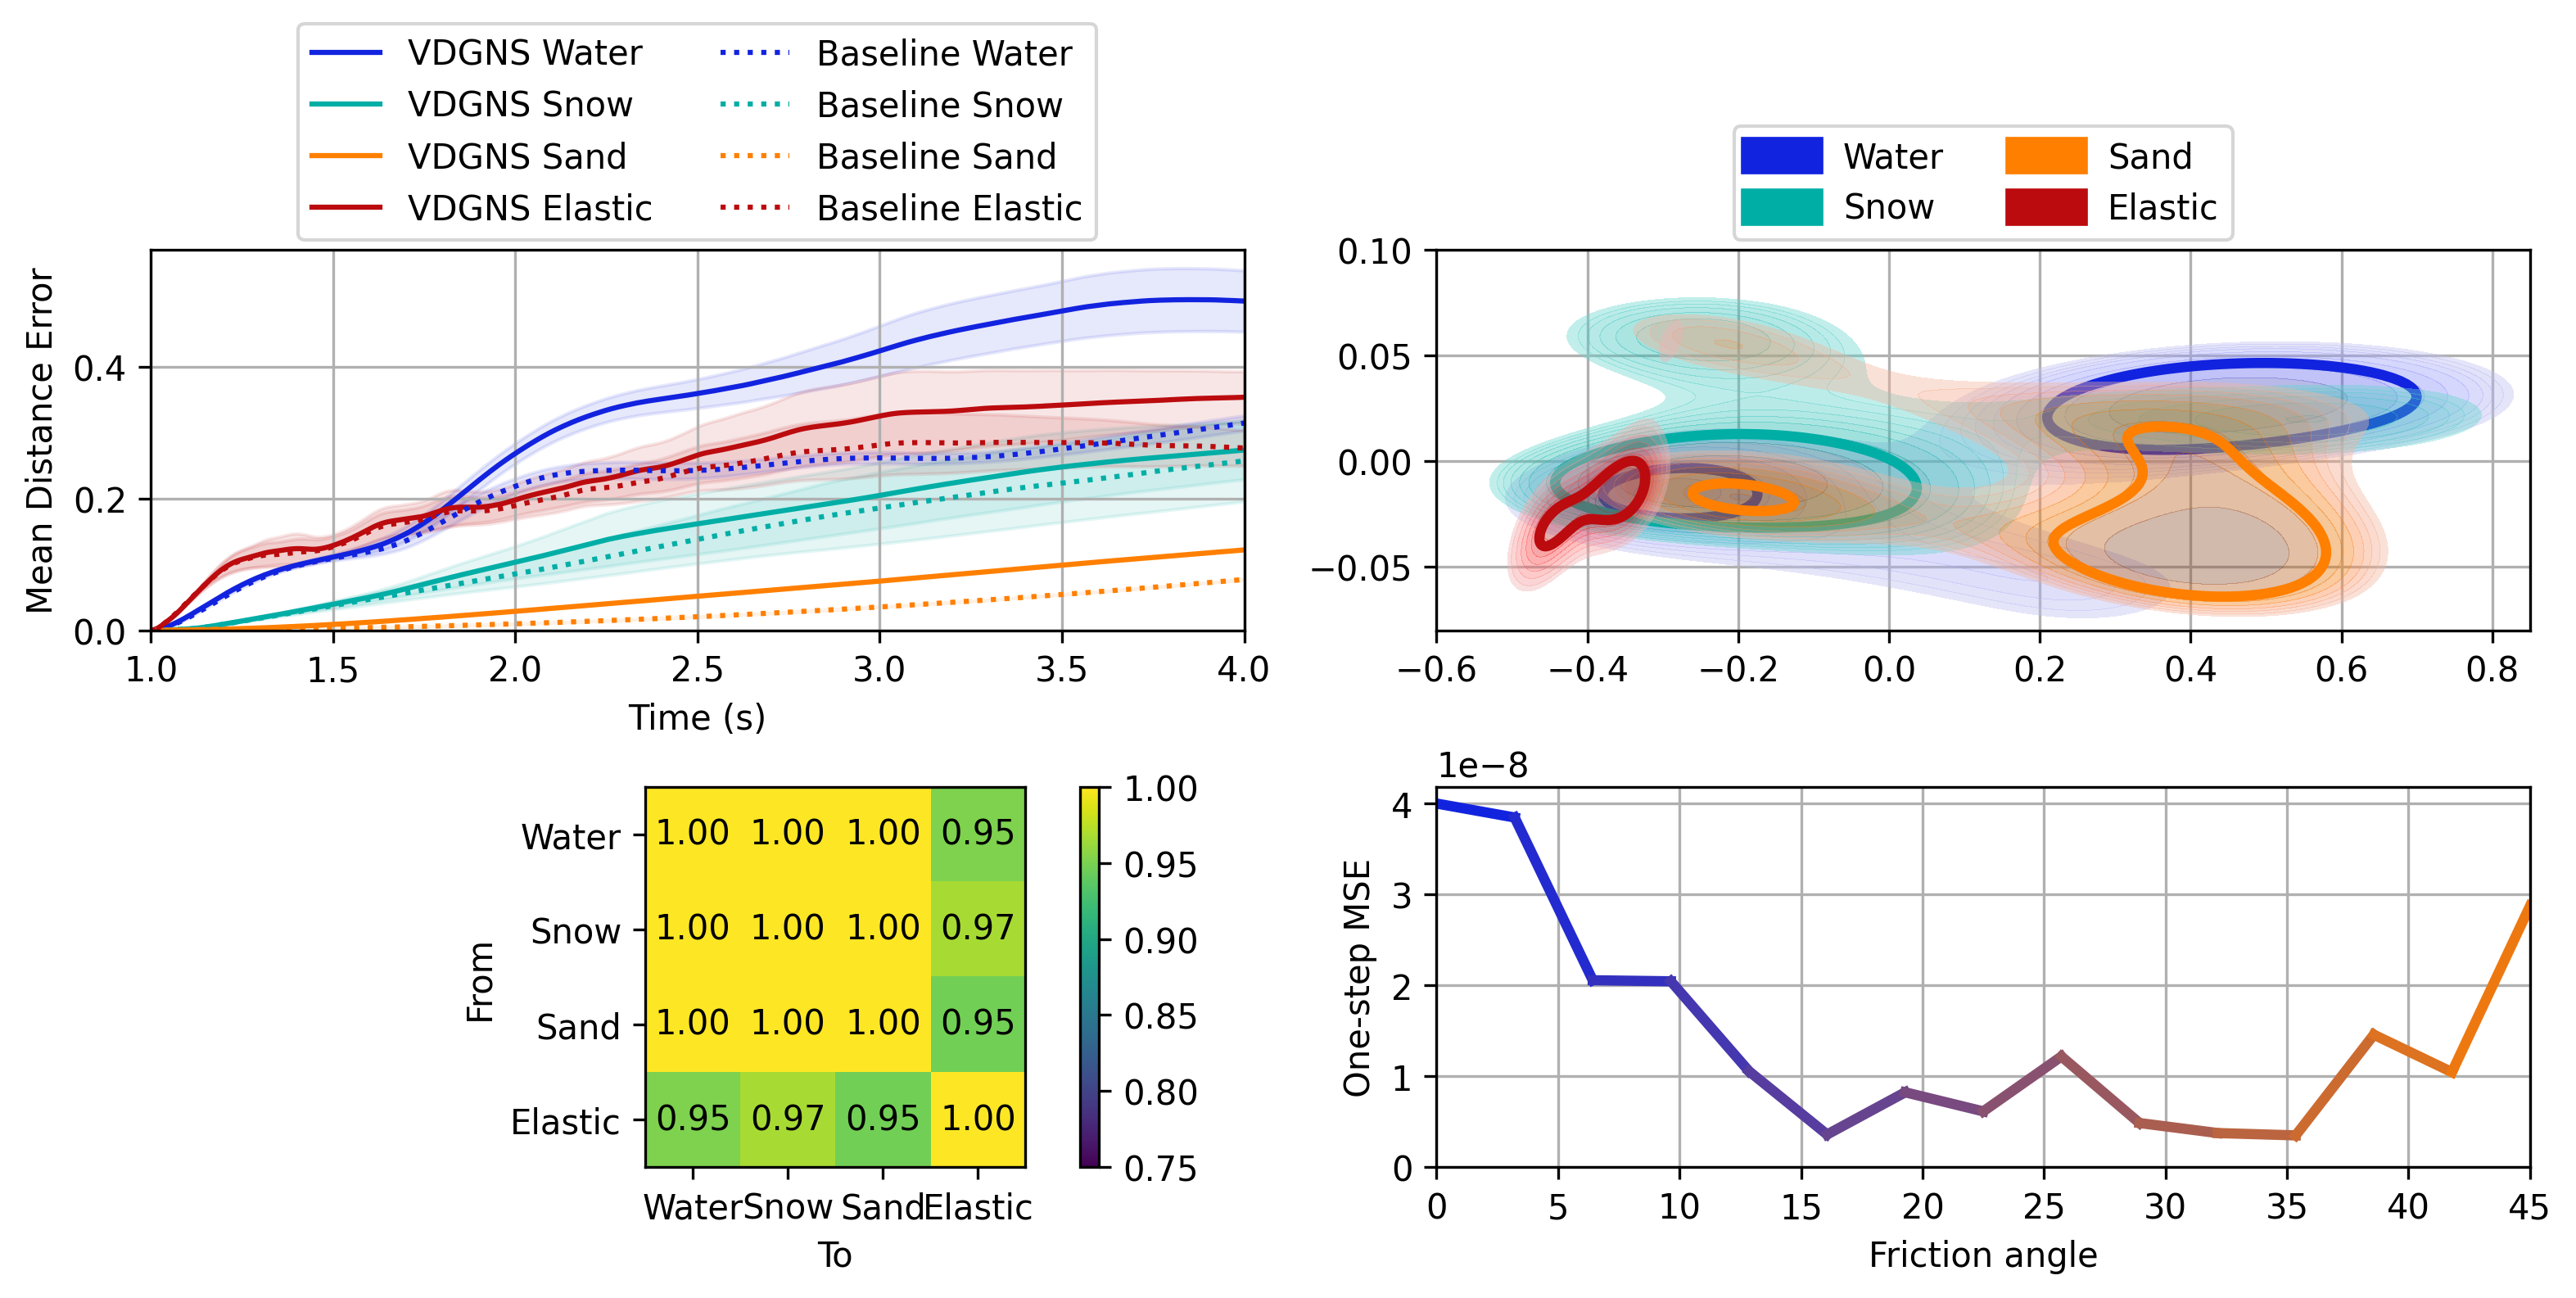

In [192]:
fig, axs = plt.subplots(2, 2, figsize=(10.5, 5.5), dpi=300)

timesteps = np.linspace(1, 4, 300)

ALPHA=0.1

ax = axs[0,0]

# VDGNS plots
ax.plot(timesteps, np.mean(vegn_rollout_errors[:30], axis=0), c=styles['water'], label='VDGNS Water')
ax.fill_between(timesteps, 
                np.mean(vegn_rollout_errors[:30], axis=0) - np.var(vegn_rollout_errors[:30], axis=0), 
                np.mean(vegn_rollout_errors[:30], axis=0) + np.var(vegn_rollout_errors[:30], axis=0), 
                color=styles['water'], alpha=ALPHA)

ax.plot(timesteps, np.mean(vegn_rollout_errors[60:90], axis=0), c=styles['snow'], label='VDGNS Snow')
ax.fill_between(timesteps, 
                np.mean(vegn_rollout_errors[60:90], axis=0) - np.var(vegn_rollout_errors[60:90], axis=0), 
                np.mean(vegn_rollout_errors[60:90], axis=0) + np.var(vegn_rollout_errors[60:90], axis=0), 
                color=styles['snow'], alpha=ALPHA)

ax.plot(timesteps, np.mean(vegn_rollout_errors[90:], axis=0), c=styles['sand'], label='VDGNS Sand')
ax.fill_between(timesteps, 
                np.mean(vegn_rollout_errors[90:], axis=0) - np.var(vegn_rollout_errors[90:], axis=0), 
                np.mean(vegn_rollout_errors[90:], axis=0) + np.var(vegn_rollout_errors[90:], axis=0), 
                color=styles['sand'], alpha=ALPHA)


ax.plot(timesteps, np.mean(vegn_rollout_errors[30:60], axis=0), c=styles['elastic'], label='VDGNS Elastic')
ax.fill_between(timesteps, 
                np.mean(vegn_rollout_errors[30:60], axis=0) - np.var(vegn_rollout_errors[30:60], axis=0), 
                np.mean(vegn_rollout_errors[30:60], axis=0) + np.var(vegn_rollout_errors[30:60], axis=0), 
                color=styles['elastic'], alpha=ALPHA)

# Baseline plots
BASE_STYLE = ':'

ax.plot(timesteps, np.mean(base_rollout_errors[:30], axis=0), c=styles['water'], label='Baseline Water', linestyle=BASE_STYLE)
ax.fill_between(timesteps, 
                np.mean(base_rollout_errors[:30], axis=0) - np.var(base_rollout_errors[:30], axis=0), 
                np.mean(base_rollout_errors[:30], axis=0) + np.var(base_rollout_errors[:30], axis=0), 
                color=styles['water'], alpha=ALPHA)

ax.plot(timesteps, np.mean(base_rollout_errors[60:90], axis=0), c=styles['snow'], label='Baseline Snow', linestyle=BASE_STYLE)
ax.fill_between(timesteps, 
                np.mean(base_rollout_errors[60:90], axis=0) - np.var(base_rollout_errors[60:90], axis=0), 
                np.mean(base_rollout_errors[60:90], axis=0) + np.var(base_rollout_errors[60:90], axis=0), 
                color=styles['snow'], alpha=ALPHA)

ax.plot(timesteps, np.mean(base_rollout_errors[90:], axis=0), c=styles['sand'], label='Baseline Sand', linestyle=BASE_STYLE)
ax.fill_between(timesteps, 
                np.mean(base_rollout_errors[90:], axis=0) - np.var(base_rollout_errors[90:], axis=0), 
                np.mean(base_rollout_errors[90:], axis=0) + np.var(base_rollout_errors[90:], axis=0), 
                color=styles['sand'], alpha=ALPHA)

ax.plot(timesteps, np.mean(base_rollout_errors[30:60], axis=0), c=styles['elastic'], label='Baseline Elastic', linestyle=BASE_STYLE)
ax.fill_between(timesteps, 
                np.mean(base_rollout_errors[30:60], axis=0) - np.var(base_rollout_errors[30:60], axis=0), 
                np.mean(base_rollout_errors[30:60], axis=0) + np.var(base_rollout_errors[30:60], axis=0), 
                color=styles['elastic'], alpha=ALPHA)

ax.grid()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Mean Distance Error')
ax.set_xlim(1, 4)
ax.set_ylim(0, None)
fig.subplots_adjust(top=0.8)
ax.legend(ncols=2, loc='upper center', bbox_to_anchor=(0.5, 1.64))

# Plotting
ax = axs[0,1]

ax.grid(True, zorder=-2)

# KDE plots with specified colors
for label, color in styles.items():
    subset = df[df['label'] == label]
    sns.kdeplot(data=subset, x='PC1', y='PC2', fill=True, color=color, alpha=0.4, label=label, ax=ax, zorder=2, thresh=0.5, levels=10)
    sns.kdeplot(data=subset, x='PC1', y='PC2', fill=False, color=color, alpha=1.0, label=label, ax=ax, zorder=2, thresh=0.85, levels=1, linewidths=3)


# Set title and labels
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xlim(-0.6, 0.85)
ax.set_ylim(-0.08, 0.1)

# Customize legend
ax.legend(handles=handles, ncol=2, bbox_to_anchor=(0.5, 1.37), loc='upper center')

ax = axs[1,0]

row_labels = ['Water', 'Snow', 'Sand', 'Elastic']
col_labels = row_labels

# Create the heatmap
heatmap = ax.imshow(results_r2_mean, cmap='viridis', interpolation='nearest', vmin=0.75)

# Add color bar to the side
plt.colorbar(heatmap, ax=ax)

# Annotate the cells with the tensor values
for i in range(results_r2_mean.shape[0]):
    for j in range(results_r2_mean.shape[1]):
        ax.text(j, i, f'{results_r2_mean[i, j]:.2f}', ha='center', va='center', color='black')

# Add labels to the rows and columns
ax.set_xticks(np.arange(len(col_labels)), col_labels)
ax.set_yticks(np.arange(len(row_labels)), row_labels)

# Title the axes
ax.set_xlabel('To')
ax.set_ylabel('From')

ax = axs[1,1]

cmap = LinearSegmentedColormap.from_list("custom_cmap", [styles['water'], styles['sand']], N=15)
colors = [cmap(i) for i in np.linspace(0, 1, 15)]

for i in range(15 - 1):
    ax.plot([friction_angles[i], friction_angles[i + 1]], [errors_friction_angles[i], errors_friction_angles[i + 1]], color=colors[i], linewidth=3)

ax.set_xlim(0, 45)
ax.set_ylim(0, None)
axs[1,1].grid()
ax.set_xlabel('Friction angle')
ax.set_ylabel('One-step MSE')

plt.tight_layout()
plt.savefig('results/all_combined_results.pdf', bbox_inches='tight')